In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/retail_transactions.csv", parse_dates=["ds"])
df = df[df["ds"] >= "2023-05-01"]
df.head()

,unique_id,ds,y,average_discount,holiday,week_before_holiday
2,Books,2023-05-01,15940.233894,2,0,0
3,Books,2023-05-02,20267.366423,2,0,0
4,Books,2023-05-03,16548.154523,1,0,0
5,Books,2023-05-04,15272.922705,1,0,0
6,Books,2023-05-05,18329.740428,1,0,0


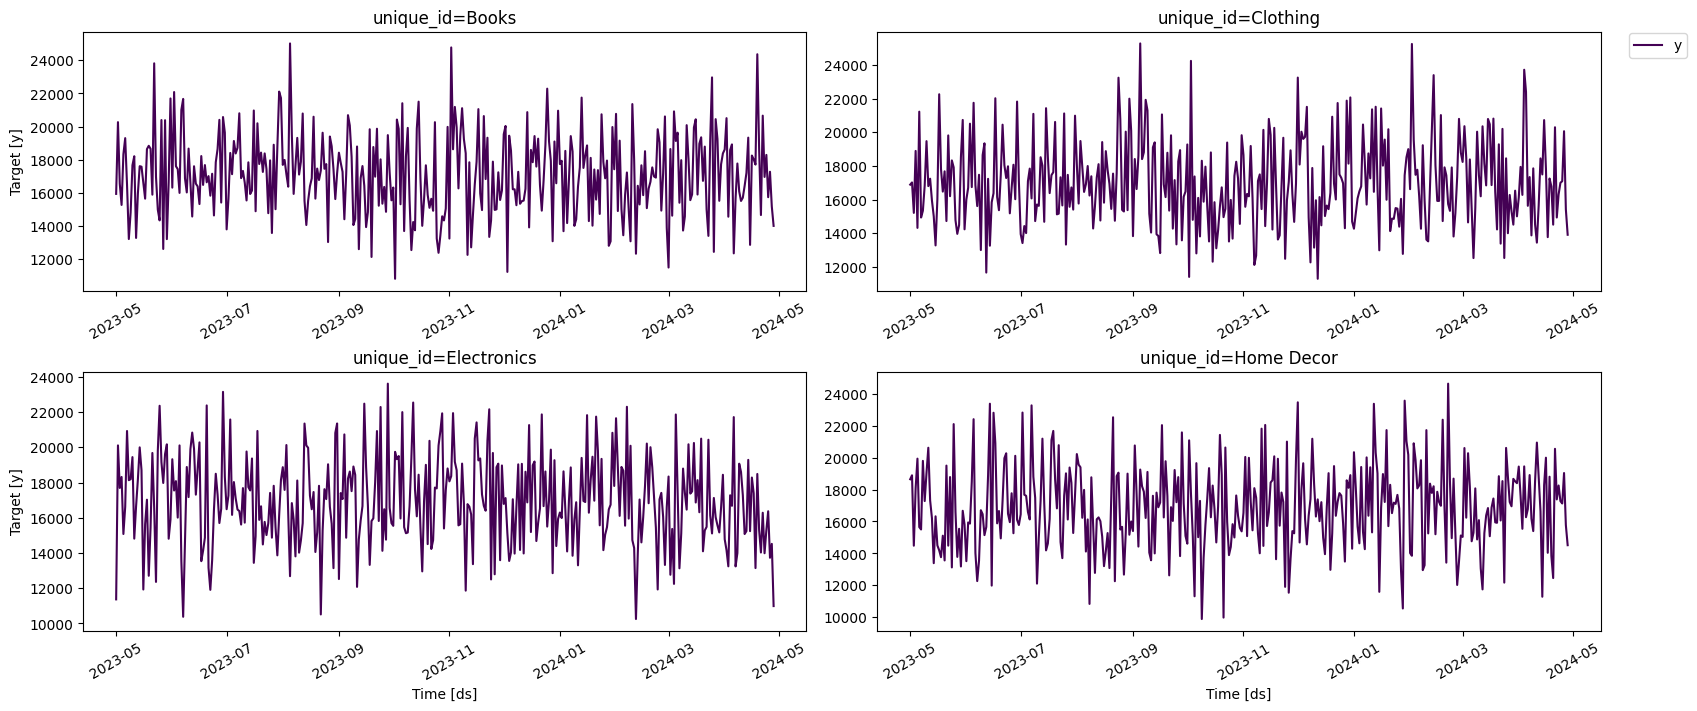

In [3]:
plot_series(df=df, palette="viridis")

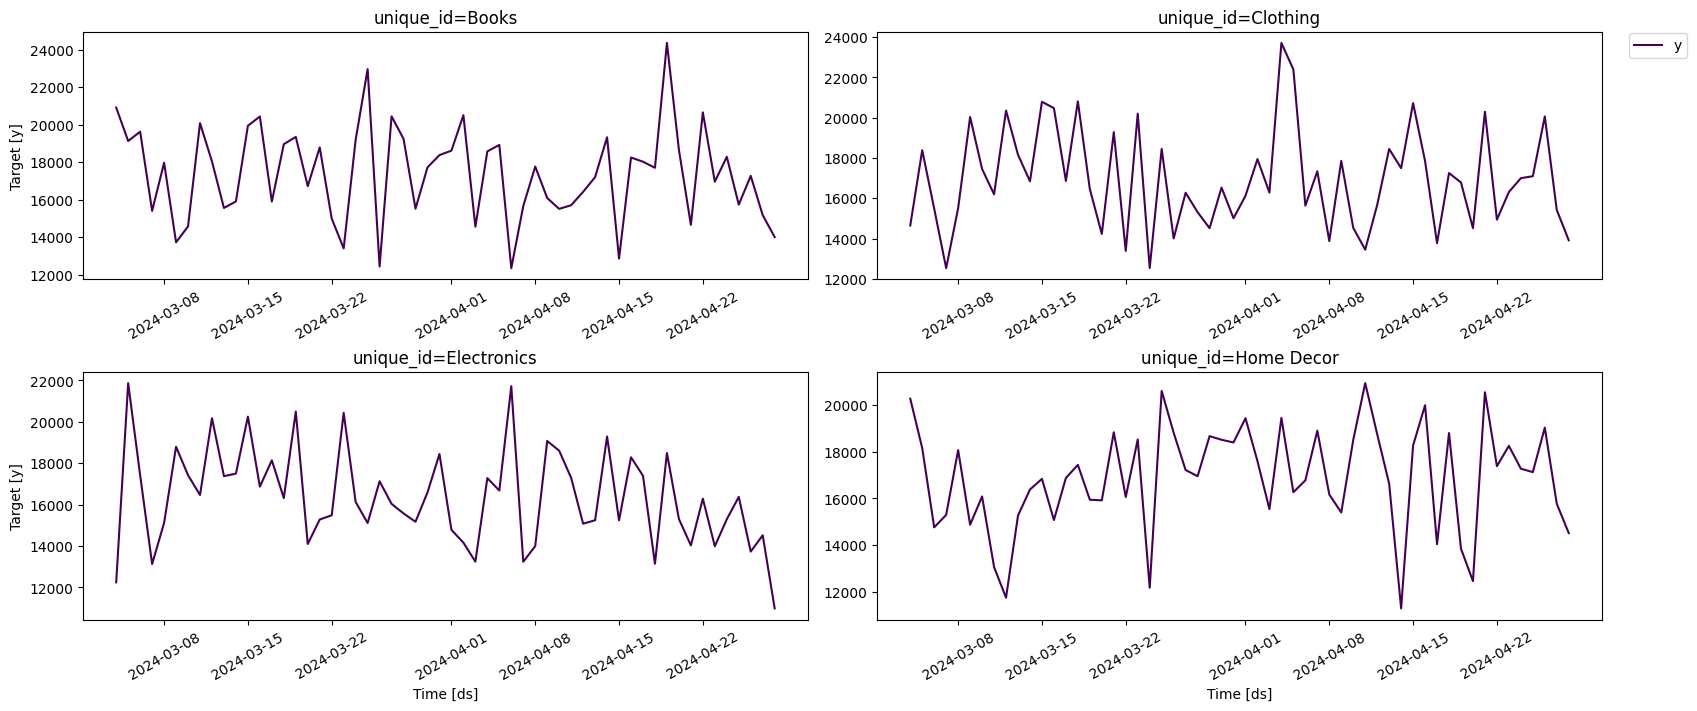

In [4]:
plot_series(df=df, max_insample_length=56, palette="viridis")

## Pretrain a model

In [6]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import MSE

2025-12-31 15:23:58,112	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-31 15:23:59,594	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [7]:
pretrain_df = df[df["unique_id"].isin(["Clothing", "Electronics", "Home Decor"])]

In [8]:
horizon = 28

models = [
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        loss=MSE(),
        valid_loss=MSE(),
        scaler_type="robust",
        early_stop_patience_steps=3,
        max_steps=1000
    )
]

nf = NeuralForecast(models=models, freq="D")
nf.fit(df=pretrain_df, val_size=horizon)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | valid_loss   | MSE               | 0      | train
2 | padder_train | ConstantPad1d     | 0      | train
3 | scaler       | TemporalNorm      | 0      | train
4 | model        | PatchTST_backbone | 425 K  | train
-----------------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00,  2.12it/s, v_num=13, train_loss_step=2.540, train_loss_epoch=2.560]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.89it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  1.91it/s, v_num=13, train_loss_step=2.440, train_loss_epoch=2.360, valid_loss=6.1
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.66it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  1.

In [9]:
nf.save(
    path="./models",
    overwrite=True,
    save_dataset=False
)

## Transfer learning

In [10]:
pretrained_model = NeuralForecast.load(path="./models")

Seed set to 1


In [11]:
books_df = df[~df["unique_id"].isin(pretrain_df["unique_id"])]

In [12]:
test_df = books_df.sort_values(["unique_id", "ds"]).tail(28)
input_df = books_df.drop(test_df.index)

### Zero-shot forecasting

In [13]:
zero_shot_fcsts = pretrained_model.predict(
    df=input_df
)
zero_shot_fcsts = zero_shot_fcsts.rename(columns={"PatchTST": "PatchTST_ZS"})
zero_shot_fcsts.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


,unique_id,ds,PatchTST_ZS
0,Books,2024-04-01,17547.355469
1,Books,2024-04-02,16904.320312
2,Books,2024-04-03,17313.996094
3,Books,2024-04-04,16165.143555
4,Books,2024-04-05,16946.257812


### Fine-tuning

In [14]:
def set_max_steps(nf, max_steps):
    trainer_kwargs = {**{"max_steps": max_steps}}
    nf.models[0].trainer_kwargs = trainer_kwargs

set_max_steps(pretrained_model, 20)

In [15]:
pretrained_model.fit(df=input_df, val_size=28)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | valid_loss   | MSE               | 0      | train
2 | padder_train | ConstantPad1d     | 0      | train
3 | scaler       | TemporalNorm      | 0      | train
4 | model        | PatchTST_backbone | 425 K  | train
-----------------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|█████████████████| 1/1 [00:00<00:00,  2.59it/s, v_num=15, train_loss_step=2.660, train_loss_epoch=2.660]

`Trainer.fit` stopped: `max_steps=20` reached.


Epoch 19: 100%|█████████████████| 1/1 [00:00<00:00,  2.58it/s, v_num=15, train_loss_step=2.660, train_loss_epoch=2.660]


In [16]:
finetuned_fcsts = pretrained_model.predict()
finetuned_fcsts = finetuned_fcsts.rename(columns={"PatchTST": "PatchTST_FT"})
finetuned_fcsts.head()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.31it/s]


,unique_id,ds,PatchTST_FT
0,Books,2024-04-01,17028.929688
1,Books,2024-04-02,16719.820312
2,Books,2024-04-03,17013.308594
3,Books,2024-04-04,16294.245117
4,Books,2024-04-05,16774.160156


### Data-specfic model

In [17]:
horizon = 28

models = [
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        loss=MSE(),
        valid_loss=MSE(),
        scaler_type="robust",
        early_stop_patience_steps=3,
        max_steps=1000
    )
]

nf = NeuralForecast(models=models, freq="D")
nf.fit(df=input_df, val_size=horizon)
fcsts = nf.predict()
fcsts.head()

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | valid_loss   | MSE               | 0      | train
2 | padder_train | ConstantPad1d     | 0      | train
3 | scaler       | TemporalNorm      | 0      | train
4 | model        | PatchTST_backbone | 425 K  | train
-----------------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00,  2.90it/s, v_num=17, train_loss_step=2.440, train_loss_epoch=2.490]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.01it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  2.39it/s, v_num=17, train_loss_step=2.020, train_loss_epoch=2.040, valid_loss=7.3
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.01it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  2.

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.68it/s]


,unique_id,ds,PatchTST
0,Books,2024-04-01,17129.523438
1,Books,2024-04-02,15452.070312
2,Books,2024-04-03,18252.949219
3,Books,2024-04-04,16336.922852
4,Books,2024-04-05,18876.205078


## Evaluation

In [18]:
test_df = pd.merge(test_df, zero_shot_fcsts, 'left', ["unique_id", "ds"])
test_df = pd.merge(test_df, finetuned_fcsts, 'left', ["unique_id", "ds"])
test_df = pd.merge(test_df, fcsts, 'left', ["unique_id", "ds"])

test_df = test_df.drop(columns=["average_discount", "holiday", "week_before_holiday"])
test_df.head()

,unique_id,ds,y,PatchTST_ZS,PatchTST_FT,PatchTST
0,Books,2024-04-01,18619.699157,17547.355469,17028.929688,17129.523438
1,Books,2024-04-02,20508.658237,16904.320312,16719.820312,15452.070312
2,Books,2024-04-03,14562.869170,17313.996094,17013.308594,18252.949219
3,Books,2024-04-04,18580.041209,16165.143555,16294.245117,16336.922852
4,Books,2024-04-05,18923.417151,16946.257812,16774.160156,18876.205078


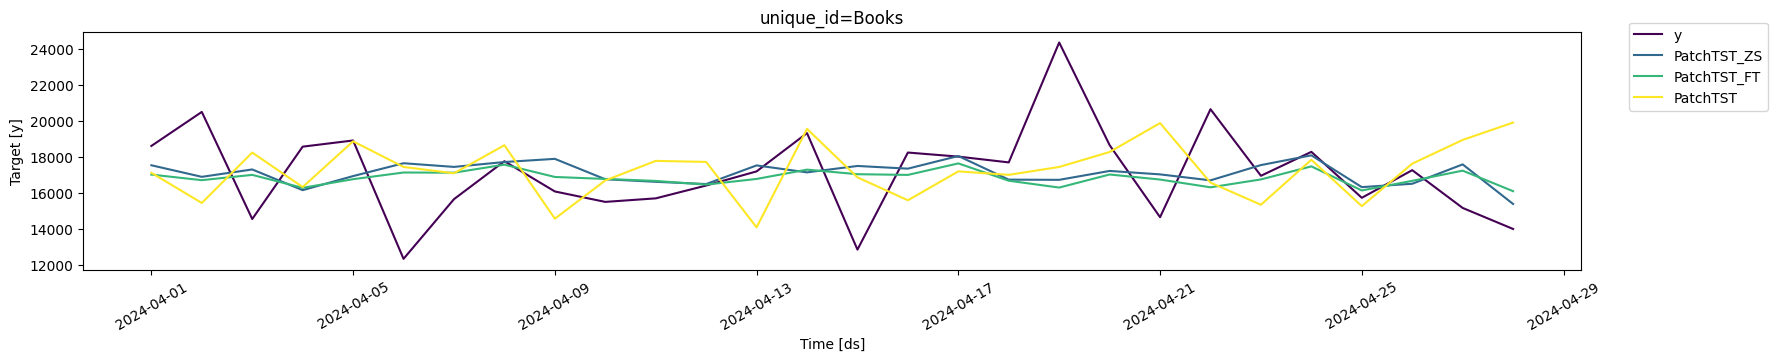

In [19]:
plot_series(df=test_df, forecasts_df=test_df.drop(columns="y"), palette="viridis")

In [20]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    agg_fn="mean"
)

evaluation

,metric,PatchTST_ZS,PatchTST_FT,PatchTST
0,mae,1907.233477,1906.503206,2382.678107
1,smape,0.055672,0.055740,0.069869
